# Recommendations with IBM

In this notebook, I will be putting my recommendation skills to use on real data from the IBM Watson Studio platform. I will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)


Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download(['punkt', 'wordnet', 'stopwords',
               'averaged_perceptron_tagger'])

%matplotlib inline


[nltk_data] Downloading package punkt to /Users/marvellousonuma-
[nltk_data]     kalu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/marvellousonuma-
[nltk_data]     kalu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/marvellousonuma-
[nltk_data]     kalu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/marvellousonuma-kalu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
df = pd.read_csv('user-item-interactions.csv')
df_content = pd.read_csv('articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Before making recommendations of any kind, let us explore the data. 

#### Missing values

In [4]:
# Check null values in df
df.isnull().sum()

article_id     0
title          0
email         17
dtype: int64

In [5]:
# Check null values in df
df_content.isnull().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

#### Comment

`df` dataframe: There are 17 missing values in **article_id** and no missing values in **email** and **title**

`df_content` dataframe: There are 14 missing values in **doc_body**, 3 missing values in **doc_description**, and no missing values in **doc_full_name**, **doc_status**, and **article_id** respectively.

#### Duplicates

In [6]:
print("The number of duplicate articles is {}".format(df_content.duplicated(['article_id']).sum()))

The number of duplicate articles is 5


In [7]:
# list the duplicated articles keeping the first
df_content[df_content.duplicated(['article_id'])]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [8]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], inplace=True)

#test 
df_content['article_id'].duplicated().sum()

0

#### Descriptive Statistics: user-item interactions

What is the distribution of how many articles a user interacts with in the dataset?

The user information is recorded in email column. We will count how many articles each user have interacted with. The groupby function will be used here

In [9]:
user_article_interactions = df.groupby('email').count()['article_id'].reset_index()
user_article_interactions.sort_values(by='article_id', ascending=False,inplace=True)
user_article_interactions.columns = ['email','count']
user_article_interactions.head()

,email,count
910,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364
2426,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363
985,2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170
3312,a37adec71b667b297ed2440a9ff7dad427c7ac85,169
2680,8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160


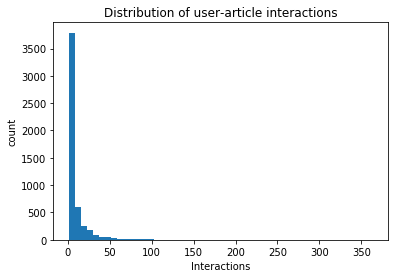

In [10]:
# Distribution of how many articles a user interacts with in the dataset
plt.figure()
plt.hist(user_article_interactions['count'], bins=50)
plt.title('Distribution of user-article interactions')
plt.xlabel('Interactions')
plt.ylabel('count')
plt.show()

In [11]:
user_article_interactions.describe()

,count
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


In [12]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with __3__ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ___364___.

#### More on descriptive Statics

We will continue exploring the datasets by answering the questions below


**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [13]:
#The number of unique articles that have an interaction with a user 
df['article_id'].nunique()

714

In [14]:
# The number of unique articles in the dataset (whether they have any interactions or not)
df_content['article_id'].nunique()

1051

In [15]:
#The number of unique users in the dataset. (excluding null values)
df['email'].nunique()

5148

In [16]:
#The number of user-article interactions in the dataset.
df.shape[0]

45993

**Putting it all together**

In [17]:
unique_articles = df['article_id'].nunique() # The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique()  # The number of unique articles on the IBM platform
unique_users = df['email'].nunique() # The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

#### Most viewed article

Goal is to find the most viewed article, as well as how often it was viewed.  

In [18]:
#create a dataframe articles_df that stores the counts of all article_id in descending order
articles_df = df.groupby('article_id').count()['title'].sort_values(ascending=False)
articles_df.head()

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: title, dtype: int64

In [19]:
#most viewed article - convert to string
str(articles_df.index[0])

'1429.0'

In [20]:
#how many times was the most viewed article
articles_df.iloc[0]

937

putting it together

In [21]:
most_viewed_article_id = str(articles_df.index[0])# The most viewed article in the dataset as a string with one value following the decimal 
max_views = articles_df.iloc[0]# The most viewed article in the dataset was viewed how many times?

### Email_Mapper function

Map the user email to a user_id column and remove the email column

In [22]:
#map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [23]:
#let us test our soluton values beore we proceed

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this method of recommendation, we recommend the most popular item to any user. The popularity is often based on highest ratings, most purchases, most listened to (in terms of  music recommendations system) etc

For our case, we don't actually have ratings for whether a user liked an article or not. We only know that a user has interacted with an article or not.

Hence here, the popularity of an article can really only be based on how often an article was interacted with.

In [24]:
# **n** top articles ordered with most interactions in descending order
articles_df = df.groupby('article_id').count()['title'].sort_values(ascending=False)
articles_df.head()

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: title, dtype: int64

In [25]:
#print the first title of articles associated with top article id 1429.0
df[df['article_id'] == 1429.0]['title'].iloc[0]

'use deep learning for image classification'

In [26]:
#print index of top  articles
print(list(articles_df.index[:10]))

[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [27]:
print([str(i) for i in articles_df.index[:10]])

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [28]:
for i in range(10):
    u=df[df['article_id'] == articles_df.index[:10][i]]['title'].iloc[0]
    print(u)

use deep learning for image classification
insights from new york car accident reports
visualize car data with brunel
use xgboost, scikit-learn & ibm watson machine learning apis
predicting churn with the spss random tree algorithm
healthcare python streaming application demo
finding optimal locations of new store using decision optimization
apache spark lab, part 1: basic concepts
analyze energy consumption in buildings
gosales transactions for logistic regression model


**Let us put them all in a function**

In [29]:
def get_top_articles(n, df=df):
    
    '''
    Function gives the title of n-top articles with highest interaction.
    INPUT:
        n - (int) the number of top articles to return
        df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
        top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = []
    for i in range(n):
        top_n_articles = df[df['article_id'] == articles_df.index[:n][i]]['title'].iloc[0]
        top_articles.append(top_n_articles)
    return top_articles # Return the top article titles from df

def get_top_article_ids(n, df=df):
    '''
    function gives the id or n-top interacted articles
    INPUT:
        n - (int) the number of top articles to return
        df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
        top_articles - (list) A list of the top 'n' article ids 
    
    '''
    # Your code here
    top_articles_id = [str(i) for i in articles_df.index[:n]]
 
    return top_articles_id # Return the top article ids

In [30]:
print(get_top_articles(10))
print()
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [31]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### Comment

We have implemented a rank-based recommendation system, a method that recommends most popular items to users. For our case study, popularity of an article here is based on how often an article was interacted with.

Our recommendation result  shows that `article_id = 1429.0` with title `use deep learning for image classification` is the most popular article in the dataset.

#### Limitations

This method of recommendations is not personalized to any user. We can make recommendations based on how users have interacted with items in the past (**User-Item Based Collaborative Filtering**), or how users have interacted with each other in the past (**User-User Based Collaborative Filtering**). 


In order to build better recommendations for the users of IBM's platform, we could look at users that are similar in terms of the items they have interacted with. These items could then be recommended to the similar users. This would be a step in the right direction towards more personal recommendations for the users. Let us now implement this.




### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>

In this type of recommendation, suppose we have a user we would like to create recommendations for, we identify other users who are similar to the user of interest, base on interactions. 

- The first thing to do is to create a user-item matrix with users as the rows and articles as the columns and based on the following conditions:  

    * Each **user** should only appear in each **row** once.
    * Each **article** should only show up in one **column**.  
    * If a user has interacted with an article, then place a 1 where the user-row meets for that article-column.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  
    * If a user has not interacted with an item, then place a zero where the user-row meets for that article-column. 

Found this [link](https://stackoverflow.com/questions/37543647/how-to-replace-all-non-nan-entries-of-a-dataframe-with-1-and-all-nan-with-0) helpful for this task.

- After we have found the list of similar users to a user id, we will make recommendations.

In [32]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values
    where a user interacted with 
    an article and a 0 otherwise
    '''
    
    #create the desired matrix
    user_item = df.groupby(['user_id','article_id'])['title'].count().unstack() 
    #We can take the return value of user_item.notnull(), which is False where the matrix contains NaN\
    #and True otherwise and cast it to integer user_item.notnull().astype(int)
    #giving us 0 where the matrix is NaN and 1 otherwise:
    user_item = user_item.notnull().astype(int)
    
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)
# save the user-item matrix in a pickle file called user_item_matrix.p
user_item.to_pickle('user_item_matrix.p')

In [33]:
## Tests the structure of matrix matches what is expected
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [34]:
#let's view the user_item matrix
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
print("The shape of user_item matrix is {} x {}".format(user_item.shape[0], user_item.shape[1]))
print("The shape of user_item matrix for user_id 1 {} ".format(user_item.loc[1].shape[0]),"x 1")

The shape of user_item matrix is 5149 x 714
The shape of user_item matrix for user_id 1 714  x 1


### Note:

To comment on the user-item matrix that we just created:
- from the table above, user `1` has interacted with article 1436, and others etc similarly, user `3` has interacted with article 1436 and others...in this regard, we say users 1 and 3 are similar. 

- To find similar users to a particular user, an appropriate measure of similarity here is a dot product of two users since the results for each user here are binary (0,1).

- The dot product will yield a 5149 x 1 matrix, matrix elements will yield the number of articles both users have interacted with. The element with the highest value (most interaction)is considered as most similar

For example, if we consider user_id 1, the similar users are given below in descending order:

In [36]:
#find users similar to user 1
user_item.dot(user_item.loc[1]).sort_values(ascending=False).head()

user_id
1       36
3933    35
23      17
3782    17
203     15
dtype: int64

so we see the top 5 users similar to user 1. As we know that each user is similar to him/herself, so it doesn't make sense including a user in the list of users similar to it. Hence asides user 1, 3933 is the most similar user to user 1, having 35 number of similar read articles

#### Let us now write a function that gives ordered list of most similar users to a user

- should take a **user_id** and provide an ordered list of the most similar users to that user (from most similar to least similar).  

- The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. 



In [37]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of the most similar users to that user in descending order
    '''
    # similarity of each user to the provided user_id sorted in descing order
    similar_users = user_item.dot(user_item.loc[user_id]).sort_values(ascending=False) 
    
    # create list of just the ids
    similar_users_index = similar_users.index 
    
    # remove the owner user's id
    most_similar_users = similar_users_index.drop(user_id) 
       
    return most_similar_users # return a list of the users in order from most to least similar
 


In [38]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(list(
    find_similar_users(1)[:10])))
print()
print("The 5 most similar users to user 3933 are: {}".format(list(
    find_similar_users(3933)[:5])))
print()
print("The 3 most similar users to user 46 are: {}".format(list(
    find_similar_users(46)[:3])))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]

The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]

The 3 most similar users to user 46 are: [4201, 23, 3782]


### Making recommendations

Now that we have a function that provides the most similar users to each user, we will want to use these users to find articles we can recommend. 

steps:

- Get article names: a list of article names associated with the list of article ids (this is identified by the title column)
                    
- Provides a list of the article_ids and article titles that have been seen by a user

- Make a list of recommendations for similar users. For example, when we find articles that a user have seen, and articles all users similar to the user have seen, we will loop through the later list and return articles not found in the former list.

Helpful link [here](https://stackoverflow.com/questions/3462143/get-difference-between-two-lists) to find difference in elements of a list.
    
**Explore before we create the function**

In [39]:
#get article name for article id 1276.0 
df[df['article_id'] == float(1276.0)]['title'].iloc[0]

'deploy your python model as a restful api'

In [40]:
#matrix element corresponding to user 1
user_item.loc[1].head()

article_id
0.0    0
2.0    0
4.0    0
8.0    0
9.0    0
Name: 1, dtype: int64

In [41]:
#list of article_ids  whether seen or not by user 1
user_item.loc[1].index

Float64Index([   0.0,    2.0,    4.0,    8.0,    9.0,   12.0,   14.0,   15.0,
                16.0,   18.0,
              ...
              1434.0, 1435.0, 1436.0, 1437.0, 1439.0, 1440.0, 1441.0, 1442.0,
              1443.0, 1444.0],
             dtype='float64', name='article_id', length=714)

In [42]:
#list of article_ids that have been seen by user 1. Corresponds to a value of 1 in matrix
user_item.loc[1][user_item.loc[1]==1].index

Float64Index([  43.0,  109.0,  151.0,  268.0,  310.0,  329.0,  346.0,  390.0,
               494.0,  525.0,  585.0,  626.0,  668.0,  732.0,  768.0,  910.0,
               968.0,  981.0, 1052.0, 1170.0, 1183.0, 1185.0, 1232.0, 1293.0,
              1305.0, 1363.0, 1368.0, 1391.0, 1400.0, 1406.0, 1427.0, 1429.0,
              1430.0, 1431.0, 1436.0, 1439.0],
             dtype='float64', name='article_id')

**Puting it all together**

In [43]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_names = []
    for article in article_ids:
        article_name = df[df['article_id'] == float(article)]['title'].iloc[0]
    
        article_names.append(article_name)
    
    return article_names # Return the article names (title) associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    user_row = user_item.loc[user_id]
    article_ids = [str(i) for i in user_row[user_row == 1].index]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    # Find viewed articles by user
    viewed_article_ids, viewed_article_names = get_user_articles(user_id)
    
    # Find similar users to user of interest
    similar_users = find_similar_users(user_id)
    
    recs = []
    for user in similar_users:
        article_ids, article_names = get_user_articles(user) #get list of articles they've seen
    
    #find article_ids in article_ids which are not in viewed_article_ids
        article_not_viewed = list(set(article_ids) - set( viewed_article_ids) )
        recs.extend(article_not_viewed)
        
        if len(recs) > m:
            break
            
    return recs[:m]

In [44]:
#top ten articles seen by user 1
viewed_article_ids, viewed_article_names = get_user_articles(1)
viewed_article_names[:10]

['deep learning with tensorflow course by big data university',
 'tensorflow quick tips',
 'jupyter notebook tutorial',
 'sector correlations shiny app',
 'time series prediction using recurrent neural networks (lstms)',
 'introduction to market basket analysis in\xa0python',
 'fighting gerrymandering: using data science to draw fairer congressional districts',
 'introducing ibm watson studio ',
 'python for loops explained (python for data science basics #5)',
 'new shiny cheat sheet and video tutorial']

In [45]:
# Return 10 recommendations for user 1
get_article_names(user_user_recs(1, 10)) 

['small steps to tensorflow',
 'analyze open data sets with pandas dataframes',
 '502    forgetting the past to learn the future: long ...\nName: title, dtype: object',
 'machine learning for the enterprise',
 'visualize data with the matplotlib library',
 'learn tensorflow and deep learning together and now!',
 'challenges in deep learning',
 'visualising data the node.js way',
 'from scikit-learn model to cloud with wml client',
 'build a python app on the streaming analytics service']

In [46]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


### Improving our recommendation

Now we are going to improve the consistency of the **user_user_recs** function from above.  The possibilities are:

1) Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions; i.e sort in descing orders


2) Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.


In [47]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
   # similarity
    user_vector = user_item.loc[user_id]
    #matrix containing other user_ids except the given user_id
    matrix_item = user_item.drop(user_id) 
    similarity_measure = np.dot(matrix_item, user_vector) #an array
    
    # sort by similarity
    df_similarity = pd.DataFrame({'neighbor_id': matrix_item.index,
                            'similarity_measure': similarity_measure})

    # Number of interaction
    num_interactions = df.groupby('user_id')['article_id'].count().drop(user_id)
   
    df_interactions = pd.DataFrame({'neighbor_id': num_interactions.index,
                             'num_interactions': num_interactions.values})

    # Merging the two dataframes, sort by similarity measure then number of interactions
    neighbors_df = df_similarity.merge(df_interactions)

    # sort the neighbors_df
    neighbors_df.sort_values(by=['similarity_measure', 'num_interactions'],
                             inplace=True, ascending=False)

    return neighbors_df


   
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    # Get sorted neighbors to user_id
    
    neighbors_df = get_top_sorted_users(user_id)
    
    # Top neighbors
    top_neighbors = list(neighbors_df[:m]['neighbor_id'])

    # articles viewed by top neighbors
    recs = []
    for user in top_neighbors:
        article_ids = user_item.loc[user]
        recs.extend([str(i) for i in article_ids[article_ids == 1].index])

    # Unique values
    recs = list(set(recs[:m]))

    # Find unique article names
    rec_names = list(set(df[df['article_id'].isin(recs)]['title']))

    return recs, rec_names

In [48]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['125.0', '205.0', '362.0', '109.0', '232.0', '12.0', '302.0', '164.0', '336.0', '142.0']

The top 10 recommendations for user 20 are the following article names:
['statistics for hackers', 'tensorflow quick tips', "a beginner's guide to variational methods", 'dsx: hybrid mode', 'timeseries data analysis of iot events by using jupyter notebook', 'learn tensorflow and deep learning together and now!', 'neural networks for beginners: popular types and applications', 'self-service data preparation with ibm data refinery', 'challenges in deep learning', 'accelerate your workflow with dsx']


#### Test our function

In [49]:
# Find the user that is most similar to user 1 
get_top_sorted_users(1).iloc[0]

neighbor_id           3933
similarity_measure      35
num_interactions        45
Name: 3931, dtype: int64

In [50]:
# Find the 10th most similar user to user 131
get_top_sorted_users(131).iloc[9]

neighbor_id           242
similarity_measure     25
num_interactions      148
Name: 240, dtype: int64

In [51]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0]['neighbor_id']# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9]['neighbor_id']# Find the 10th most similar user to user 131

In [52]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


### Business Problem - Cold-Start problem

A new user to the IBM Watson platform would have no observed articles. Thus what would your recommendations be for this new user? That is, which of the above functions would you be able to use to make recommendations? 

> A better way to make recommendations for a new user is to use **rank-based recommendation** method where the most popular articles accross the user base are recommended. 
This implies using the `get_top_article_ids` function we defined in the rank-based recommendation section.

> However, since the rank-based recommendation method might not be relevant to the user given that it is not a personalized recommendation, we might actualy improve it by using **knowledge-based recommendation** method, where we ask users to provide pieces of information about the types of articles they are interested in and look throughout our data for articles that meet the user specifications. 

Let us now provide the top 10 recommended articles we would provide for the new user.  

In [53]:
new_user = '0.0'


# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Your recommendations here
print(new_user_recs)

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [54]:
#test function .
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations </a>

Another popular technique for making recommendations is called **content-based recommendations**. In this recommendation technique, we use information that is known about the user or item to make recommendations. This method of making recommendations is particularly useful when we do not have a lot of user-item connections available in our dataset.

It might be the case that content-based and collaborative filtering-based techniques come up with similar recommendations, but the methods by which data scientists approach these recommendations are very different. In collaborative filtering, you are using the connections of users and items (as you did before). In content-based techniques, you are using information about the users and items, but not connections (hence the use when you do not have a lot of internal data already available to use).

Given the amount of content available for each article, there are a number of different ways in which someone might choose to implement a content based recommendations system. We will consider content to be the **doc_body**, **doc_description**, or **doc_full_name** all provided in the `df_content` dataframe

- We will create a dataframe including all articles in IBM Watson-studio
- Next we will apply NPL to process the title column in our dataframe
- we will create similarity matrix of all articles 
- Then we will make some recommendations.

In [55]:
df_content.head(2)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1


Our feature of interest is **doc_full_name**. Let us check for mossing values and duplicates

#### Missing values & Duplicates

In [56]:
df_content['doc_full_name'].isnull().sum() #no missing values

0

In [57]:
df_content['doc_full_name'].duplicated().sum() #no duplicates

0

So we will apply NLP to process them. First let us define a tokenize function that processes the text data.

In [58]:
def tokenize(text):
    """Function to tokenize a given document text
    INPUT:
        text- string, document description
    OUTPUT:
        tokens- (list) a list of words associated with document decription
    """

    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

    # tokenize text
    tokens = word_tokenize(text)

    # lemmatize and remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens
              if word not in stop_words]
    # remove short words
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

In [59]:
#text function
print(df_content['doc_full_name'].iloc[0])
print()
print(tokenize(df_content['doc_full_name'].iloc[0]))


Detect Malfunctioning IoT Sensors with Streaming Analytics

['detect', 'malfunctioning', 'iot', 'sensor', 'streaming', 'analytics']


So our tokenize() function works as expected. 

What we want to do next is to create a dataframe that contains all the articles in the IBM Watson's platform. This is given by **title** column in `df` dataframe and **doc_full_name** in `df_content` dataframe respecticely. Let us see this for article_id = 4 for example 

In [60]:
df[df['article_id']==4.0].head(2)

,article_id,title,user_id
18856,4.0,analyze ny restaurant data using spark in dsx,2345
23372,4.0,analyze ny restaurant data using spark in dsx,176


In [61]:
df_content[df_content['article_id']==4.0]

,doc_body,doc_description,doc_full_name,doc_status,article_id
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


So we see that **title == doc_full_name**. However, the difference lies in capitalization of certain words. Thus a good practise would be to apply NLP for text processing. 

#### TODO:

- create a dataframe of relevant features, one each for df and df_content
- concatenate the two dataframe and remove duplicates.
- apply NLP to our new (merged) dataframe.

### Create dataframe of all articles in the platform

In [62]:
def create_content_dataframe(df=df, df_content=df_content):
    '''
    This function creates a dataframe of all articles in the IBM Watson's platform and 
    processes the article title (a text data) using NLP tool.
    
    INPUT:
        df - pandas dataframe as described at the top of the notebook
        df_content - pandas dataframe described at the top of the notebook
    
    OUTPUT:
        df_merge - pandas dataframe containing all articles in the platform
        article_content -  pandas dataframe with description of the content of each
                       article on the platform

    '''

    # create a dataframe of the full article from df and df_content
    df1 = df.loc[:,['article_id', 'title']] #subset from df
    df2 = pd.DataFrame({'article_id': df_content['article_id'].values,
                         'title': df_content['doc_full_name']}) #subset from df_content
    
    #merge the two dataframe
    df_merge = pd.concat([df1, df2], ignore_index=True)
    df_merge.drop_duplicates(subset=['article_id'], inplace=True) #drop duplicated article_id
    df_merge.sort_values(by='article_id', inplace=True) #order by article_id in ascending order
    df_merge.reset_index(drop=True, inplace=True) 

      
    # initialize tf-idf vectorizer object
    # Tf-idf Vectorizer on title column in df_merge
   # This, however, returns a sparse matrix, which I can actually turn into a dense matrix via
    v = TfidfVectorizer(tokenizer=tokenize)
    # compute bag of word counts and tf-idf values
    df_v = pd.DataFrame(v.fit_transform(
                          df_merge['title'].values).toarray(),
                          columns=[*v.vocabulary_])

    # concat  df_merge and df_v
    article_content = pd.concat([df_merge, df_v], axis=1)

    return df_merge, article_content


df_merge, article_content = create_content_dataframe()

In [63]:
#view few rows in article_contet dataframe
article_content.head(2)

,article_id,title,detect,malfunctioning,iot,sensor,streaming,analytics,communicating,data,...,welcome,caused,challenger,disaster,marriage,tourism,region,1948,2010,1000
0,0.0,detect malfunctioning iot sensors with streami...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,Communicating data science: A guide to present...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
article_content.loc[:,'title'].head(2)

,title,title
0,detect malfunctioning iot sensors with streami...,0.0
1,Communicating data science: A guide to present...,0.0


#### observation
so we observe there are two title columns in the article_content dataframe. We will now rename the first title column to article_title

In [65]:
#here the title columns are renamed as title_i according to ther index i.
cols = []
count = 1
for column in article_content.columns:
    if column == 'title':
        cols.append(f'title_{count}')
        count+=1
        continue
    cols.append(column)
article_content.columns = cols

#rename again for user friendliness
article_content.rename(columns={ 'title_1': "article_title", 'title_2': "title" },inplace=True)

### Creating article-similarity matrix

In [66]:
def find_similar_articles(article_id):
    
    article_contents = np.array(article_content.iloc[:,2:])

    # Take the dot product to obtain an article x article matrix of similarities
    dot_prod_article = article_contents.dot(np.transpose(article_contents))
    #As a final note, you may need to adjust the criteria for 'most similar' to obtain 10 recommendations. As a first pass, I used only movies with the highest possible similarity to one another as similar enough to add as a recommendation.

    #pull articles we want
    #article_idx = article_content[article_content['article_id']== article_id].index[0]
    article_idx = np.where(article_content['article_id'] == article_id)[0][0]
    #find articles that are similar to that article
    similar_idxs = np.where(dot_prod_article[article_idx] >0)[0]
    #pull article title base on indices
    similar_articles = np.array(article_content.iloc[similar_idxs,]['article_title'])
    return similar_articles

### Make content-based recommendation

In [67]:
def make_content_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    df_smly - (pandas dataframe) pandas dataframe that describe the articles
    similarities using the dot product

    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    '''
    rec=[]

    viewed_article_ids, viewed_article_names = get_user_articles(user_id)
    seen_article_name=np.array(viewed_article_names)
    seen_article_id=np.array(viewed_article_ids)
    seen_article_ids = np.array([float(i) for i in seen_article_id])


    for article in seen_article_ids:
        rec_article = find_similar_articles(article)
        temp_recs = np.setdiff1d(rec_article, seen_article_name)
            
        rec.extend(list(temp_recs))
        if len(rec) > m:
            break
                
    rec=rec[:m]
    return(rec)


In [68]:
#test our recommendation: top 10 articles recommended for user 1427
make_content_recs(1427)

['10 data science, machine learning and ai podcasts you must listen to',
 '10 essential algorithms for machine learning engineers',
 "2875    hugo larochelle's neural network & deep learni...\nName: title, dtype: object",
 '3 scenarios for machine learning on multicloud',
 '5 practical use cases of social network analytics: going beyond facebook and twitter',
 '56594    lifelong (machine) learning: how automation ca...\nName: title, dtype: object',
 '8 ways to turn data into value with apache spark machine learning',
 'A Deep Dive into Offline First with PouchDB and IBM Cloudant',
 'A Deep Dive into Offline-First with PouchDB and IBM Cloudant',
 'Cloudant Learning Center']

### Discussion

We have built a content-based recommendation system base on complete information about all articles in the IBM Watson platform. 
- We merged **doc_full_name** in `df_content` to **title** in `df` to arrive at datarame of all article contents in the platform

- Next we processed the text **title** column using tools from NLP. We filtered the dataframe by extracting only the columns with article content.
- We created an article-similarity matrix by taking the dot product of the filtered dataframe with its transpose
- Finally, given a user id, we can make recommendations by looking for most similar articles to the articles seen by the user.

 - find articles that are similar to those a user have seen
 - make recommendations (extract those the users have not seen from the similar articles)
 
To improve on this recommendation, out of all articles that are similar to the articles user have seen, we could consider the most popular (with stronger similarity) and make recommendations.

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

So far, we have created knowledge-based recommendations. But, 

- How do we know when our recommendations are good?
- How do we use machine learning to make recommendations?
- How to recommend to new users in the platform? `cold start problem`

In this part of the notebook, we will complete a machine learning approach to building recommendations. 
- Using the user-item interactions we created earlier, we will build out a matrix decomposition. 
- Using your decomposition, you will get an idea of how well you can predict new articles an individual might interact with (spoiler alert - it isn't great). 
- You will finally discuss which methods you might use moving forward, and how you might test how well your recommendations are working for engaging users.

we will use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

Let us recall the **user_item matrix** from previous sections:

In [69]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [70]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Singular Value Decomposition (SVD)

Let us apply the SVD from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user_item matrix.

#### user-item matrix decomposition

Our user-item matrix contain binary values with zero representing no overlap and 1 representing overlap. Thus a suitable decomposition algorithm is the `singular value decomposition`. 

Other type of decomposition algorithm we could consider is Funk svd. However, the Funk svd algorithm is especially useful for matrices with lots of missing values, Funk SVD would have to be used to provide a numeric approximation.


In [71]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

In [72]:
# Checking matrices dimensions
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

### Latent Features

Latent factors are features that aren't actually observed in the data, but can be inferred based on the relationships that occur.

You can see that this matrix doesn't have any specific information about the users or articles. Rather, it just holds the interactions that each user have with an article. 

Using SVD on this matrix, we can find latent features related to the articles and users. This is amazing because the dataset doesn't contain any information about the users or articles!

The question is:

- How do we choose the number of latent features to use? 

Let us explore how the recommendation accuracy is affected by number of latent features. 

In [73]:
num_latent_feats = np.arange(10,700+10,20) #number of latent features
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    

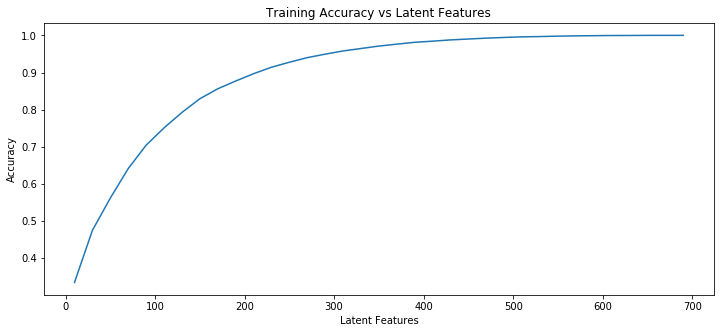

In [74]:
plt.figure(figsize=(12,5))
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Latent Features');
plt.ylabel('Accuracy');
plt.title('Training Accuracy vs Latent Features');

We see here that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  

However, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. 

Instead, we might split our dataset into a training and test set of data and then try to understand the impact on accuracy of the training and test sets of data with different numbers of latent features

In [75]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    # User-item matrix of the training dataframe
    user_item_train = create_user_item_matrix(df_train)
    
    # User-item matrix of the testing dataframe 
    user_item_test = create_user_item_matrix(df_test)
    
    # Test user ids
    test_idx = user_item_test.index
    test_idx = list(set(test_idx))
    
    # Test article ids
    test_arts = user_item_test.columns
    test_arts = list(set(test_arts))
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

#### Data exploration

In [76]:
user_item_train.shape

(4487, 714)

In [77]:
user_item_test.shape

(682, 574)

In [78]:
# How many users can we make predictions for in the test set?
len(np.intersect1d(df_train['user_id'].unique(),df_test['user_id'].unique()))


20

In [79]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
len(df_test['user_id'].unique()) - len(np.intersect1d(df_train['user_id'].unique(),df_test['user_id'].unique()))

662

In [80]:
# How many articles can we make predictions for in the test set?
len(np.intersect1d(df_train['article_id'].unique(),df_test['article_id'].unique()))

574

In [81]:
# How many articles in the test set are we not able to make predictions for because of the cold start problem?
len(df_test['article_id'].unique()) - len(np.intersect1d(df_train['article_id'].unique(),df_test['article_id'].unique()))

0

In [82]:
#test our code

a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
    }

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


### TODO:
- We will use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. 
- Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

#### Find U, S and V transpose using SVD on user_item_train dataset

In [83]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) 

# Checking matrices dimensions
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

#### Finding subset of rows in user_item_test dataset that we can predict.

In [84]:
# Subset of rows (users) in the user_item_test dataset that you can predict

#  Rows that match the test set
test_idx = user_item_test.index
row_idxs = user_item_train.index.isin(test_idx)
u_test = u_train[row_idxs, :]

#  Columns that match the test set
test_col = user_item_test.columns
col_idxs = user_item_train.columns.isin(test_col)
vt_test = vt_train[:, col_idxs]

# Test data
train_idx = user_item_train.index
row_idxs_2 = user_item_test.index.isin(train_idx)
user_pred = np.intersect1d(user_item_train.index,user_item_test.index)
user_item_test_actual = user_item_test.loc[user_pred]


In [85]:
num_latent_feats = np.arange(10,700+10,20) #number of latent features
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_k, u_train_k, vt_train_k = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    u_test_k, vt_test_k = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_k, s_train_k), vt_train_k))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_k, s_train_k), vt_test_k))
    
    # compute error for each prediction to actual value (prediction - actual values)
    diffs = np.subtract(user_item_test_preds, user_item_test_actual)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

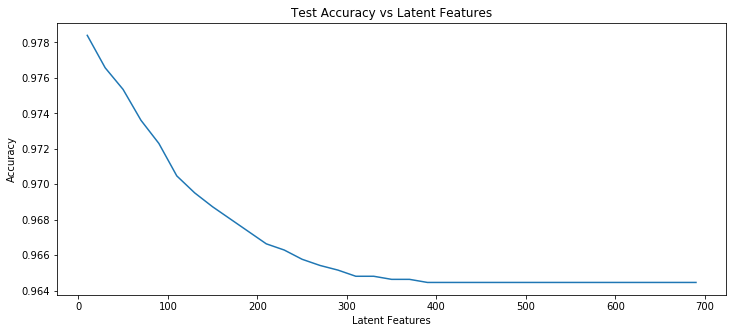

In [86]:
# Plot test accuracy and latent features
plt.figure(figsize=(12,5))
n_interactions_set =user_item_test_actual.shape[0] * user_item_test_actual.shape[1]
plt.plot(num_latent_feats, 1 - (np.array(sum_errs) / n_interactions_set));
plt.xlabel('Latent Features');
plt.ylabel('Accuracy');
plt.title('Test Accuracy vs Latent Features');

### Comment


The figure of Test Accuracy vs Latent Features shows that overall, the accuracy of the model is very high. However this may be misleading as we have a class imbalance in our data where there are more zeros (no interactions) than ones (interactions). Thus accuracy might not be a best measurement metric. 

Similary, the testing accuracy decreases as the number of latent features increases. This negative relationship could be due to the few number (20) of users we have in the test data that we are bale to make predictions for, an insufficient data to compare predictions to actual values. To solve this problem, we could use cross validation technique to determine the best parameter for the latent features.

To determine if a recommendation is an improvement to how users currently find articles, we would conduct an A/B test to measure the effective of a recommendation system to other. For example, we could measure the effectiveness of a content based recommendation system against the matrix recommendation system. 

To conduct the experiment, we would separate users using cookies into equal number groups. Group A would use the content based recommendations while group B would use the matrix based recommendations.


In [87]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0